# Exploring the Data

This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/data-exploration.ipynb). It explores some of the data contained in or derived from the database. First we must import the necessary installed modules.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

Next we need to import a local module to calculate some advanced stats not stored in the database.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from nba.database import Database

The code below simply customizes font sizes for all the plots that follow.

In [3]:
plt.rc('font', size=14)        # controls default text sizes
plt.rc('axes', titlesize=16)   # fontsize of the axes title
plt.rc('axes', labelsize=16)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)  # fontsize of the tick labels
plt.rc('ytick', labelsize=14)  # fontsize of the tick labels
plt.rc('legend', fontsize=14)  # legend fontsize

We then need to connect to the database generated during the [data wrangling](data-wrangling.md) process.

In [4]:
conn = sqlite3.connect('../nba.db')

Without knowing what two teams are playing, a reasonable baseline prediction is probably that the home team wins. Let's take a look at how often that actually happens in the NBA. The SQL query below calculates the home team's winning percentage since the 1990-91 season and groups the results by season. Specifically, it sums up all occurrences of 'W' in the HOME_WL column and divides by the total number of games in a given season.

In [5]:
data = pd.read_sql('''
    SELECT SEASON,
           100.0 * SUM(CASE WHEN HOME_WL = 'W' THEN 1 ELSE 0 END) / COUNT(HOME_WL) AS HomeWinPct
    FROM games
    WHERE SEASON >= 1990
    GROUP BY SEASON''', conn)

The plot below shows home team win percentage across the league from 1990-2015. The chart along with the annotation show that the home team wins about 60% of the time historically. That rate is also remarkably consistent. It has a standard deviation of less than 2% and has stayed within about $$\pm$$4% since the 1990-91 season. FiveThirtyEight [reported](https://fivethirtyeight.com/features/a-home-playoff-game-is-a-big-advantage-unless-you-play-hockey/) a similar percentage when analyzing home court/field/ice advantages of the four major American sports. They calculated that the home team in the NBA has won 59.9% of regular season games since the 2000 season. They also estimated that playing at home provides the biggest advantage in the NBA, where home teams win nearly 10% more games than expected had all games been played at neutral sites. Contrast that with MLB, where home teams win only 4% more games than expected. It is interesting to note that regardless of the sport, FiveThirtyEight's models expect the "home" team to win about 50% of the time on neutral sites, which makes sense when averaged across all teams and multiple seasons.

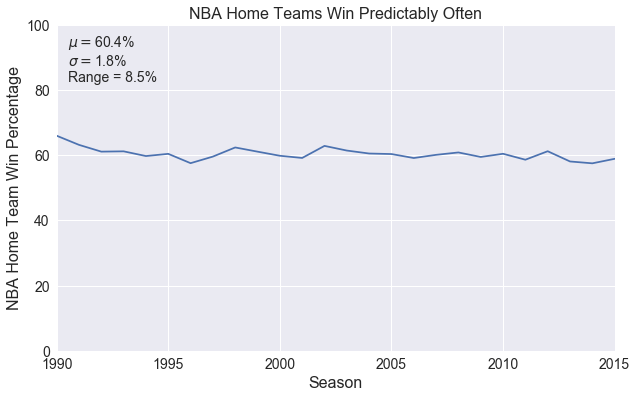

In [6]:
pct = data.HomeWinPct
plt.figure(figsize=(10, 6))
plt.plot(data.SEASON, pct)
plt.text(1990.5, 83,
         '$\mu=${0:.1f}%\n$\sigma=${1:.1f}%\nRange = {2:.1f}%'
         .format(np.mean(pct), np.std(pct), np.ptp(pct)))
plt.xlabel('Season')
plt.ylabel('NBA Home Team Win Percentage')
plt.title('NBA Home Teams Win Predictably Often')
plt.xlim(1990, 2015)
plt.ylim(0, 100)
plt.show()

Now let's calculate some advanced stats from the basic box score data. The code below returns a Pandas DataFrame with season-averaged team offensive and defensive ratings (points scored/allowed per 100 possessions), as well as SRS defined during [data wrangling](data-wrangling.md).

In [7]:
database = Database('../nba.db')
season_stats = database.season_stats()

We are first going to look at teams that have some of the best offenses and defenses in NBA history. Since the team stats table includes a team ID that maps to a teams table, we need to pull in the teams table to better identify which teams we are looking at.

In [8]:
teams = pd.read_sql('SELECT * FROM TEAMS', conn)

Below are the limits for what defines a great offense, defense, and well-balanced team (high net rating). These limits are not formally defined and are merely selected such that the resulting number of teams is small.

In [9]:
off_lim = 114
def_lim = 98
net_lim = 9
off_flag = (season_stats.TEAM_OFF_RTG > off_lim) & (season_stats.SEASON >= 1990)
def_flag = (season_stats.TEAM_DEF_RTG < def_lim) & (season_stats.SEASON >= 1990)
net_flag = (season_stats.TEAM_NET_RTG > net_lim) & (season_stats.SEASON >= 1990)
stats = ['SEASON', 'TEAM_ID', 'TEAM_OFF_RTG', 'TEAM_DEF_RTG', 'TEAM_NET_RTG', 'TEAM_SRS']

There are 13 teams since the 1990-91 season with an offensive rating greater than 114 and 4 of them are Jordan-led Bulls teams. The only other teams to appear more than once are the Suns (one led by Charles Barkley and two by the duo of Steve Nash and Amar'e Stoudemire) and the Warriors (one led by hall of famer Chris Mullin and the record-setting 2015-16 team). Note that the NBA's database does not differentiate teams that change location and/or mascots, so the table identifies the 1994 Oklahoma City Thunder, even though they were the Seattle SuperSonics at the time.

In [10]:
# Isolate desired teams
best_off = season_stats.loc[off_flag, stats]

# Merge with teams table to add team information
best_off = teams.merge(best_off, left_on='ID', right_on='TEAM_ID')

# Remove ID columns
best_off = best_off[[c for c in best_off.columns if 'ID' not in c]]

# Sort by descending offensive rating
best_off.sort_values(by='TEAM_OFF_RTG', ascending=False)

,ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
2,CHI,Chicago,Bulls,1991,116.189211,105.151816,11.037395,10.068209
3,CHI,Chicago,Bulls,1995,115.933867,102.438493,13.495374,11.799077
7,ORL,Orlando,Magic,1994,115.824746,108.447942,7.376804,6.438905
11,OKC,Oklahoma City,Thunder,1994,115.429696,106.876043,8.553653,7.907164
10,PHX,Phoenix,Suns,2009,115.341356,110.211671,5.129685,4.677408
1,CHI,Chicago,Bulls,1990,115.229301,105.703474,9.525826,8.565998
12,UTA,Utah,Jazz,1994,114.985616,106.354448,8.631169,7.751535
8,PHX,Phoenix,Suns,1994,114.930813,110.902597,4.028215,3.849692
9,PHX,Phoenix,Suns,2004,114.531469,107.143974,7.387495,7.076859
6,GSW,Golden State,Warriors,2015,114.495585,103.776436,10.719149,10.380270


There are 11 teams since 1990 with a defensive rating under 98 and 3 of them are late 90s/early 2000s Spurs teams with Tim Duncan, two of which featured hall of famer David Robinson. What is more impressive is that they are the only team to grace this list more than once.

In [11]:
# Isolate desired teams
best_def = season_stats.loc[def_flag, stats]

# Merge with teams table to add team information
best_def = teams.merge(best_def, left_on='ID', right_on='TEAM_ID')

# Remove ID columns
best_def = best_def[[c for c in best_def.columns if 'ID' not in c]]

# Sort by ascending defensive rating
best_def.sort_values(by='TEAM_DEF_RTG')

,ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
9,SAS,San Antonio,Spurs,2003,102.248071,94.178366,8.069705,7.512427
7,SAS,San Antonio,Spurs,1998,104.036733,95.000784,9.035949,7.151218
10,DET,Detroit,Pistons,2003,102.057437,95.440557,6.616880,5.035363
0,ATL,Atlanta,Hawks,1998,100.516244,97.138526,3.377719,2.790164
3,IND,Indiana,Pacers,2003,103.866828,97.324036,6.542792,4.932295
2,ORL,Orlando,Magic,1998,100.297189,97.382225,2.914964,3.082168
1,NYK,New York,Knicks,1998,98.636273,97.471817,1.164456,1.423433
4,PHI,Philadelphia,76ers,1998,99.928127,97.632210,2.295917,2.528796
6,POR,Portland,Trail Blazers,1998,104.759421,97.734222,7.025199,5.697009
8,SAS,San Antonio,Spurs,2000,106.556068,97.962401,8.593667,7.916999


The 16 teams listed below have a net rating greater than 9 and are some of the strongest teams in NBA history. These include 4 of the Jordan-led Bulls and two of the recent Warriors teams. Only one of the stong defensive teams isolated above make the cut, while 5 of the stong offensive teams appear. As before, note that the 1993 Oklahoma City Thunder were in fact the Seattle SuperSonics.

In [12]:
# Isolate desired teams
best_net = season_stats.loc[net_flag, stats]

# Merge with teams table to add team information
best_net = teams.merge(best_net, left_on='ID', right_on='TEAM_ID')

# Remove ID columns
best_net = best_net[[c for c in best_net.columns if 'ID' not in c]]

# Sort by descending net rating
best_net.sort_values(by='TEAM_NET_RTG', ascending=False)

,ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
4,CHI,Chicago,Bulls,1995,115.933867,102.438493,13.495374,11.799077
5,CHI,Chicago,Bulls,1996,114.352283,102.373550,11.978733,10.697142
12,SAS,San Antonio,Spurs,2015,110.290021,98.962236,11.327785,10.276618
0,BOS,Boston,Celtics,2007,110.171323,98.933715,11.237609,9.307345
3,CHI,Chicago,Bulls,1991,116.189211,105.151816,11.037395,10.068209
8,GSW,Golden State,Warriors,2015,114.495585,103.776436,10.719149,10.380270
7,GSW,Golden State,Warriors,2014,111.603607,101.354296,10.249311,10.008125
1,CLE,Cleveland,Cavaliers,2008,112.441598,102.432204,10.009394,8.680389
14,OKC,Oklahoma City,Thunder,2012,112.398592,102.609581,9.789011,9.149670
15,UTA,Utah,Jazz,1996,113.642224,103.950239,9.691985,7.969128


The following table shows all NBA champions since the 1990-91 season. Not surprisingly, most of the champions have solid net ratings and SRS numbers with the 1995 Bulls shining above all other teams. The weakest champion by these measures is the 1994 Rockets led by hall of famers Hakeem Olajuwon and Clyde Drexler.

In [13]:
# Create champions table that identifies which team won the NBA championship each season
champs = pd.DataFrame({'SEASON': range(1990, 2016),
                       'ABBREVIATION': ['CHI', 'CHI', 'CHI', 'HOU', 'HOU', 'CHI', 'CHI', 'CHI', 'SAS',
                                        'LAL', 'LAL', 'LAL', 'SAS', 'DET', 'SAS', 'MIA', 'SAS', 'BOS',
                                        'LAL', 'LAL', 'DAL', 'MIA', 'MIA', 'SAS', 'GSW', 'CLE']})
# Isolate desired stats from all teams
champ_stats = season_stats[stats]

# Merge with teams table to add team information
champ_stats = teams.merge(champ_stats, left_on='ID', right_on='TEAM_ID')

# Merge with champs table created above
columns = ['ABBREVIATION', 'SEASON']
champ_stats = champs.merge(champ_stats, left_on=columns, right_on=columns)

# Remove ID columns
champ_stats = champ_stats[[c for c in best_net.columns if 'ID' not in c]]
champ_stats

,ABBREVIATION,CITY,MASCOT,SEASON,TEAM_OFF_RTG,TEAM_DEF_RTG,TEAM_NET_RTG,TEAM_SRS
0,CHI,Chicago,Bulls,1990,115.229301,105.703474,9.525826,8.565998
1,CHI,Chicago,Bulls,1991,116.189211,105.151816,11.037395,10.068209
2,CHI,Chicago,Bulls,1992,113.620324,106.822864,6.797459,6.192637
3,HOU,Houston,Rockets,1993,106.444671,101.900362,4.544309,4.194021
4,HOU,Houston,Rockets,1994,110.403045,108.140634,2.262411,2.318131
5,CHI,Chicago,Bulls,1995,115.933867,102.438493,13.495374,11.799077
6,CHI,Chicago,Bulls,1996,114.352283,102.373550,11.978733,10.697142
7,CHI,Chicago,Bulls,1997,107.696343,99.779691,7.916652,7.244613
8,SAS,San Antonio,Spurs,1998,104.036733,95.000784,9.035949,7.151218
9,LAL,Los Angeles,Lakers,1999,107.325502,98.224840,9.100663,8.413792


The scatter plot below shows all teams since 1990 represented by their offensive and defensive ratings. The strongest teams are towards the bottom right, those that score a lot and do not give up many points. The line represents a constant net rating of 9, below which are the 16 teams listed above that have a net rating greater than 9.

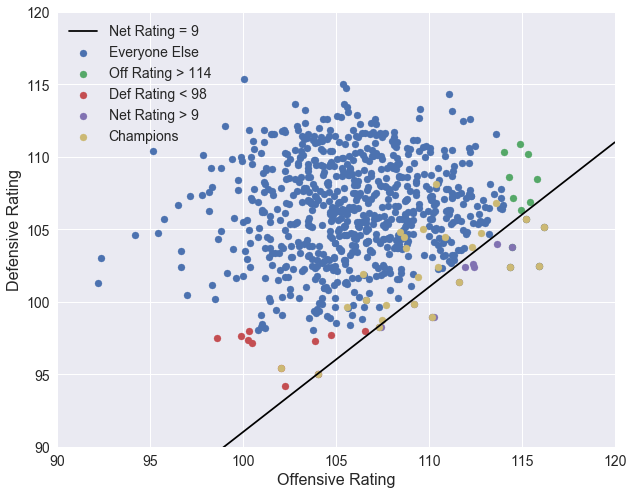

In [14]:
# Add line of constant net rating
x = np.array([95, 120])
plt.figure(figsize=(10, 8))
plt.plot(x, x-net_lim, 'black', label='Net Rating = %d' % net_lim)

# Isolate teams that do not make the offensive/defensive/net rating cutoffs
others = season_stats.loc[~off_flag & ~def_flag & ~net_flag & (season_stats.SEASON >= 1990), stats]
others = teams.merge(others, left_on='ID', right_on='TEAM_ID')

# Remove the champions with an outer join
columns = ['ABBREVIATION', 'SEASON']
others = champs.merge(others, left_on=columns, right_on=columns, how='outer', indicator=True)
others = others[others._merge == 'right_only']

# Plot data
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=others, label='Everyone Else')
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=best_off, label='Off Rating > %d' % off_lim)
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=best_def, label='Def Rating < %d' % def_lim)
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=best_net, label='Net Rating > %d' % net_lim)
plt.scatter(x='TEAM_OFF_RTG', y='TEAM_DEF_RTG', data=champ_stats, label='Champions')

# Label axes and add legend
plt.legend()
plt.xlabel('Offensive Rating')
plt.ylabel('Defensive Rating')
plt.xlim(90, 120)
plt.ylim(90, 120)
plt.show()

The histogram and KDE of team SRS below show that teams are fairly normally distributed. The best fit normal distribution has a mean of essentially zero with a standard deviation of about 4.6 points. A zero-mean distribution makes sense here because an SRS of zero indicates a perfectly average team.

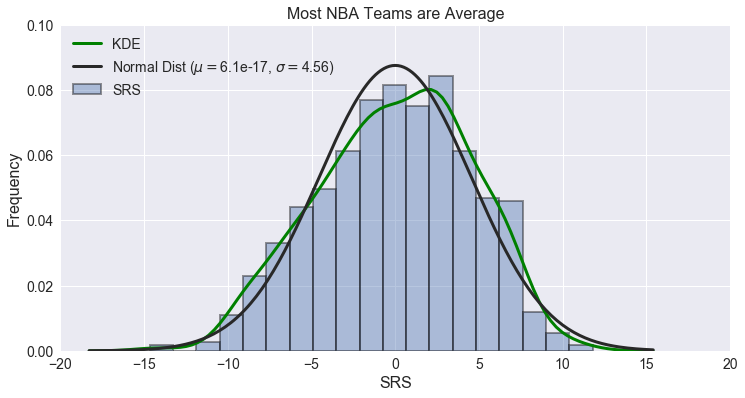

In [15]:
srs = season_stats['TEAM_SRS']
(mu, sigma) = norm.fit(srs)

plt.figure(figsize=(12, 6))
ax = sns.distplot(srs, fit=norm, kde=True, kde_kws={'label': 'KDE', 'color': 'green', 'linewidth': 3},
                  hist_kws={'label': 'SRS', 'edgecolor': 'k', 'linewidth': 2},
                  fit_kws={'label': 'Normal Dist ($\mu=${0:.2g}, $\sigma=${1:.2f})'.format(mu, sigma),
                           'linewidth': 3})
ax.legend()
plt.xlabel('SRS')
plt.ylabel('Frequency')
plt.title('Most NBA Teams are Average')
plt.xlim(-20, 20)
plt.ylim(0, 0.1)
plt.show()

The next step is to look at games in terms of home and away team stats. The code below joins the games table with the stats table initially by home team stats and followed by away team stats.

In [16]:
seasons = season_stats.filter(regex='SEASON|TEAM')
games = pd.read_sql('SELECT * FROM games', conn)
games = games.merge(seasons, left_on=['SEASON', 'HOME_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'])
games = games.merge(seasons, left_on=['SEASON', 'AWAY_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'], 
                    suffixes=('', '_OPP'))

The plot below shows a 2D KDE that compares home and away team SRS. By inspection, the majority of games occur between teams with SRS values within 5 points of average. This makes intuitive sense given the standard deviation of 4.6 points calculated above. Assuming the Gaussian distribution above, more than 68% of all teams since 1990 have SRS values with a magnitude less than 5 based on the definition of a normal distribution. The distribution appears symmetric about a y=x line because under normal circumstances (each team plays a full season), teams have the same number of home and away games. 

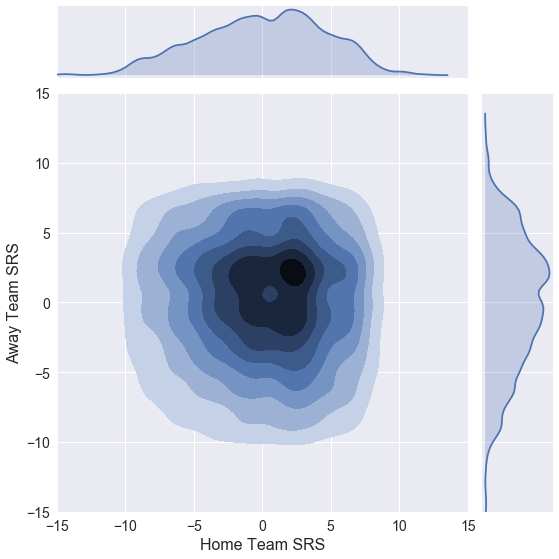

In [17]:
ax = sns.jointplot(x='TEAM_SRS', y='TEAM_SRS_OPP', data=games, kind='kde',
                   shade_lowest=False, stat_func=None, xlim=(-15, 15), ylim=(-15, 15), size=8)
ax.set_axis_labels(xlabel='Home Team SRS', ylabel='Away Team SRS')
plt.show()

The function below makes and customizes KDE plots of home and away team stats.

In [18]:
def kde(data, stat, label, title, ax):
    stat = 'TEAM_' + stat
    sns.kdeplot(data[stat], data[stat + '_OPP'], cmap='Blues', shade=True, shade_lowest=False, ax=ax)
    ax.plot(0, 0, 'or')
    ax.set_xlabel('Home Team ' + label)
    ax.set_ylabel('Away Team ' + label)
    ax.set_title(title)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)

A better view of this data is to separate games into home team wins and losses. The plots below show KDE plots of SRS for home team wins and losses with a red marker added to easily identify the origin (average home and away teams). The high-density area towards the lower right of the orgin for home team wins (left plot) indicates there are many games in the dataset where above-average home teams beat below-average away teams, which is not a surprising revelation. We draw the opposite conclusion for home team losses. The highest density occurs towards the upper left of the orgin, meaning games where a below-average home team plays an above-average visiting teams typically does not go well for the home team. There is also a small cluster of games in the left plot where above-average home teams beat above-average visitors of roughly equal quality. This may be caused by home court advantage, but was not investigated further.

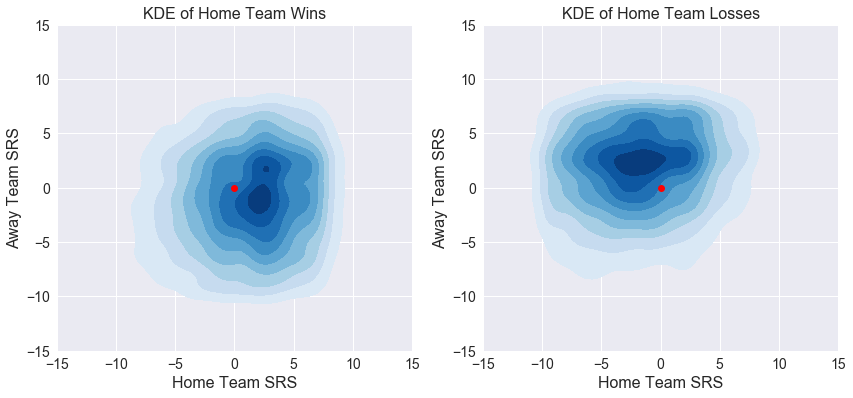

In [19]:
plt.figure(figsize=(14, 6))

# Find games where the home team won
kde(games[games.HOME_WL=='W'], 'SRS', 'SRS', 'KDE of Home Team Wins', plt.subplot(121))

# Find games where the home team lost
kde(games[games.HOME_WL=='L'], 'SRS', 'SRS', 'KDE of Home Team Losses', plt.subplot(122))

plt.show()

The KDE plots below repeat those above for team net ratings (offensive rating - defensive rating). They illustrate that the same trends hold true for net ratings as did for SRS above.

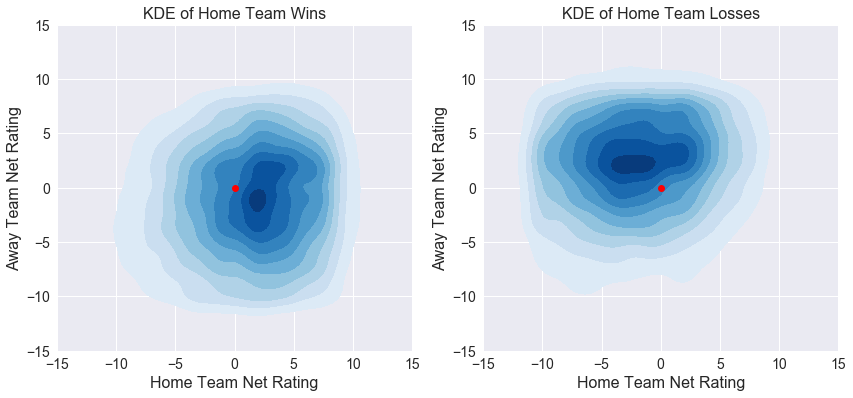

In [20]:
plt.figure(figsize=(14, 6))

# Find games where the home team won
kde(games[games.HOME_WL=='W'], 'NET_RTG', 'Net Rating', 'KDE of Home Team Wins', plt.subplot(121))

# Find games where the home team lost
kde(games[games.HOME_WL=='L'], 'NET_RTG', 'Net Rating', 'KDE of Home Team Losses', plt.subplot(122))

plt.show()